# Assignment

Motivation

To understand clustering techniques and use them to solve a biomedical problem

Study summary

The department of developmental biology is interested in exploring if expression data from a number of genes can be used to identify specific cell types. They used a publicly available dataset to run a pilot study and explore if there are specific patterns in the data supporting their hypothesis (to be used in question number 1). Assuming that their hypothesis would be supported by their analysis, they also initiated a parallel study sequencing their own data, for which the information about each cell type was available (to be used in question 2).

Goals:

    To evaluate the performance of different clustering techniques identifying cell types based on gene expression (use only the pilot dataset).
        Compare quantitatively the performance of K-means, DBSCAN and OPTICS identifying clusters of gene expression that may be associated with cell types. Justify parameter selection independently for each algorithm. How similar are the results obtained from the three algorithms?
        What is the most likely number of cell types based on previous results? Justify the answer using only the pilot dataset.
    To evaluate the performance of clustering techniques on a separate dataset (use the test dataset).
        Evaluate quantitatively the performance of the previous methods in the new dataset for which the cell types are known.
        Compare the performance of previous clustering techniques with linear discriminant analysis. Justify any difference in the obtained results.

Note: support your discussion with plots and graphic representation when possible.


# Notes

- Criteria to evaluate multiple AUROCs
    - Normalize the distribution of the predicted probabilities??
- Use the 1st dataset to get an initial idea of the clustering
- Can do PCA before clustering
- Use silhouette score to measure the separability of the clusters (SS is high when data is well clustered)
- Use Rand index to compare clustering methods
- Run K-means a few times with different initialization methods

For Q2

- Use **Rand index** to compare performance against ground truth
- Use LDA as a supervised classification method, making use of ground truth

Selecting PCA components

- Elbow method
- When plotting components, use cumulative variance

For DBScan and Optics

- Consider unassigned samples (k = -1) as the noise cluster
-


In [2]:
import numpy as np
import pandas as pd
import scipy
import shelve
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import category_encoders as ce
import seaborn as sns
from scipy.stats import normaltest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
from scipy.stats import shapiro
from scipy.special import expit
from sklearn import svm
import shelve

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.metrics import rand_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
df = pd.read_excel("./Pilot_GeneExpressionData.xlsx")
df.head()

,Expression - gene 000,Expression - gene 001,Expression - gene 002,Expression - gene 003,Expression - gene 004,Expression - gene 005,Expression - gene 006,Expression - gene 007,Expression - gene 008,Expression - gene 009,...,Expression - gene 090,Expression - gene 091,Expression - gene 092,Expression - gene 093,Expression - gene 094,Expression - gene 095,Expression - gene 096,Expression - gene 097,Expression - gene 098,Expression - gene 099
0,-1.237358,38.642584,10.884096,-3.339147,-1.555339,14.407978,55.770644,13.109897,11.652522,365.928797,...,68.662581,1.343553,20.079415,48.342081,5.199666,8.582158,325.058081,413.412361,655.467974,224.045697
1,-2.093798,39.399697,5.863917,-2.270315,-0.486506,9.469040,60.626785,9.492048,17.507333,365.129055,...,79.764261,12.445233,11.953880,52.238938,-0.116666,4.537059,321.012982,413.379518,655.339022,224.529880
2,14.470170,36.381095,-9.510318,15.156488,16.940296,-7.909798,74.697892,-4.465825,12.619979,335.499965,...,73.074749,5.755721,16.613457,55.059154,4.151859,5.631896,322.107819,411.768780,655.437052,224.088647
3,-3.074387,39.030519,9.228330,-3.344361,-1.560553,12.287957,58.692670,11.807070,15.281483,366.153522,...,68.135925,0.816897,22.837977,49.460210,7.882375,8.555372,325.031295,411.803469,655.470397,223.914104
4,-0.898006,39.088386,4.945750,-1.124616,0.659192,8.204751,61.690854,8.721729,16.890130,362.689877,...,77.619769,10.300741,14.478982,50.745263,1.451071,5.621678,322.097601,413.323667,655.363004,224.430544


In [4]:
df.columns

Index(['Expression - gene 000', 'Expression - gene 001',
       'Expression - gene 002', 'Expression - gene 003',
       'Expression - gene 004', 'Expression - gene 005',
       'Expression - gene 006', 'Expression - gene 007',
       'Expression - gene 008', 'Expression - gene 009',
       'Expression - gene 010', 'Expression - gene 011',
       'Expression - gene 012', 'Expression - gene 013',
       'Expression - gene 014', 'Expression - gene 015',
       'Expression - gene 016', 'Expression - gene 017',
       'Expression - gene 018', 'Expression - gene 019',
       'Expression - gene 020', 'Expression - gene 021',
       'Expression - gene 022', 'Expression - gene 023',
       'Expression - gene 024', 'Expression - gene 025',
       'Expression - gene 026', 'Expression - gene 027',
       'Expression - gene 028', 'Expression - gene 029',
       'Expression - gene 030', 'Expression - gene 031',
       'Expression - gene 032', 'Expression - gene 033',
       'Expression - gene 034',

In [5]:
# scale
scaler = StandardScaler()
scaler.fit(df)
df_scaled = df.copy()
df_scaled[df_scaled.columns] = scaler.transform(df_scaled[df_scaled.columns])
df_scaled

,Expression - gene 000,Expression - gene 001,Expression - gene 002,Expression - gene 003,Expression - gene 004,Expression - gene 005,Expression - gene 006,Expression - gene 007,Expression - gene 008,Expression - gene 009,...,Expression - gene 090,Expression - gene 091,Expression - gene 092,Expression - gene 093,Expression - gene 094,Expression - gene 095,Expression - gene 096,Expression - gene 097,Expression - gene 098,Expression - gene 099
0,-0.994282,0.687334,1.776193,-1.264263,-1.264263,1.796548,-1.983312,1.697186,-0.875690,1.261420,...,-0.734028,-0.734028,-0.042573,0.072869,-0.045028,0.255168,0.255168,0.553266,0.743268,-0.482682
1,-1.131703,1.345353,0.924748,-1.093720,-1.093720,1.029080,-1.015096,0.976320,1.105676,1.186345,...,1.697964,1.697964,-1.539411,1.021816,-1.578010,-1.478094,-1.478094,0.513691,-1.718768,1.664098
2,1.526070,-1.278162,-1.682793,1.686895,1.686895,-1.671439,1.790398,-1.804824,-0.548286,-1.595051,...,0.232524,0.232524,-0.681051,1.708584,-0.347167,-1.008973,-1.008973,-1.427191,0.152882,-0.292252
3,-1.289043,1.024494,1.495368,-1.265095,-1.265095,1.467115,-1.400719,1.437594,0.352411,1.282516,...,-0.849400,-0.849400,0.465593,0.345151,0.728539,0.243691,0.243691,-1.385392,0.789531,-1.066146
4,-0.939832,1.074788,0.769023,-0.910913,-0.910913,0.832620,-0.802942,0.822832,0.896805,0.957370,...,1.228180,1.228180,-1.074251,0.658082,-1.125948,-1.013352,-1.013352,0.446393,-1.260889,1.223661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,1.228493,-1.089554,-1.315560,1.437895,1.437895,-1.355997,1.481970,-1.464543,-0.541559,-1.347921,...,-0.327925,-0.327925,-0.266342,0.985223,-0.028991,-0.378705,-0.378705,-0.818278,0.456137,-0.479690
4890,-0.536842,0.409139,0.648765,-0.664373,-0.664373,0.703987,-0.613038,0.670365,-0.005218,0.592088,...,-1.152452,-1.152452,0.700248,-1.351760,0.437566,1.180009,1.180009,1.624683,0.793669,-0.310781
4891,-0.742256,1.236809,0.049874,-0.569492,-0.569492,0.227904,0.005919,0.158542,1.775241,0.693789,...,1.202002,1.202002,-1.159131,0.582664,-1.239385,-1.036762,-1.036762,0.646469,-1.471725,1.437058
4892,-0.356776,0.616459,-0.249308,-0.065730,-0.065730,-0.218167,0.449738,-0.158182,1.314788,0.167974,...,0.309907,0.309907,0.065409,0.317018,0.168926,-0.205938,-0.205938,-0.741244,0.111938,-0.196420


Text(0.5, 1.0, 'PCA explained variance')

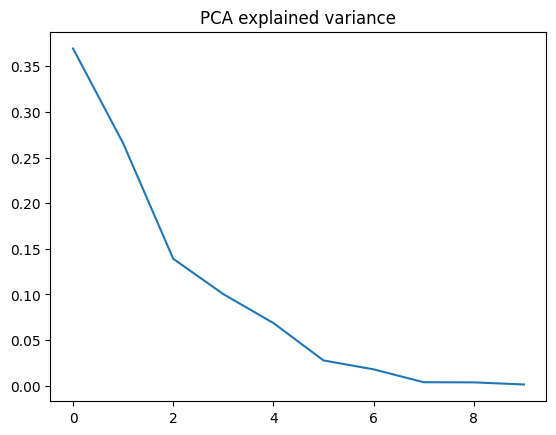

In [6]:
pca = PCA()
pca.fit(df_scaled)
plt.plot([i for i,_ in enumerate(pca.components_[0:10])], pca.explained_variance_ratio_[0:10])
plt.title('PCA explained variance')

## Pilot K-means

In [7]:
# to-do: differentiate the (K v SS) plots between k-means++ and random init methods 
def kmeans_ss(df):
    K = list(range(2, 20))
    init_methods = ['k-means++', 'random']

    ks_and_inits = list(itertools.product(K, init_methods))
    d = {'k-means++': {'k': [], 'ss': []}, 'random': {'k': [], 'ss': []}}
                                            
    for pair in ks_and_inits:
        k = pair[0] 
        init_method = pair[1] 
        km = KMeans(n_clusters=k, init=init_method, n_init='auto', random_state=0)
        km.fit(df)
        score = silhouette_score(df, km.labels_)
        if init_method == 'k-means++':
            d['k-means++']['k'].append(k)
            d['k-means++']['ss'].append(score)
        if init_method == 'random':
            d['random']['k'].append(k)
            d['random']['ss'].append(score)
    return(d)
    
res = kmeans_ss(df_scaled)


In [8]:
def plot_kmeans_ss(k, ss, figsize = (10,10), str_title = 'K versus SS'):
    plt.plot(k, ss)
    idx_max_ss = ss.index(max(ss))
    best_k = k[idx_max_ss]
    plt.vlines([best_k], ymin=0, ymax = max(ss), linestyles= "dashed", colors="black")
    plt.title(f'{str_title} (max ss at k={best_k})')
    plt.xlabel('k')
    plt.ylabel('ss')
    plt.xticks(range(0, 21, 2))

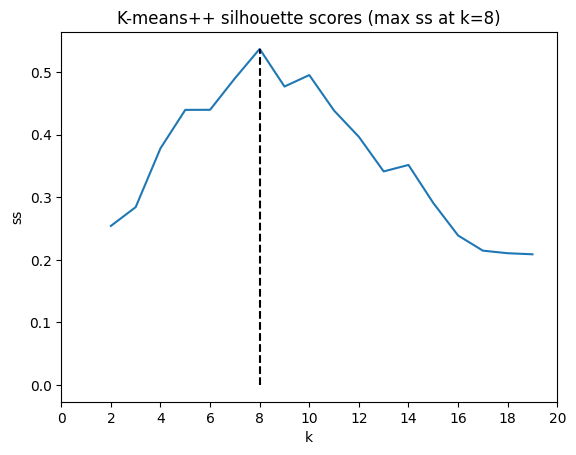

In [9]:
plot_kmeans_ss(res['k-means++']['k'], res['k-means++']['ss'], str_title="K-means++ silhouette scores")

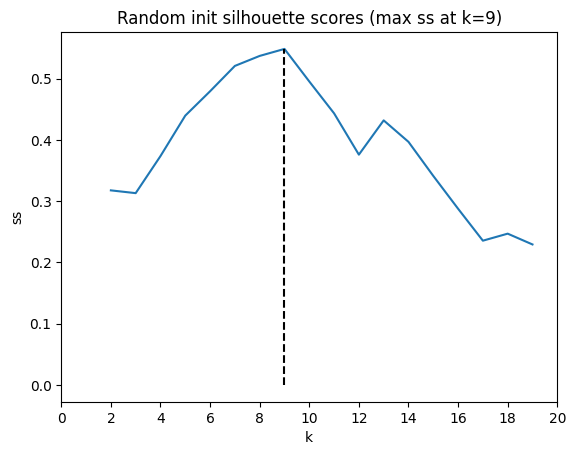

In [10]:
plot_kmeans_ss(res['random']['k'], res['random']['ss'], str_title="Random init silhouette scores")

In [11]:
df_scaled

,Expression - gene 000,Expression - gene 001,Expression - gene 002,Expression - gene 003,Expression - gene 004,Expression - gene 005,Expression - gene 006,Expression - gene 007,Expression - gene 008,Expression - gene 009,...,Expression - gene 090,Expression - gene 091,Expression - gene 092,Expression - gene 093,Expression - gene 094,Expression - gene 095,Expression - gene 096,Expression - gene 097,Expression - gene 098,Expression - gene 099
0,-0.994282,0.687334,1.776193,-1.264263,-1.264263,1.796548,-1.983312,1.697186,-0.875690,1.261420,...,-0.734028,-0.734028,-0.042573,0.072869,-0.045028,0.255168,0.255168,0.553266,0.743268,-0.482682
1,-1.131703,1.345353,0.924748,-1.093720,-1.093720,1.029080,-1.015096,0.976320,1.105676,1.186345,...,1.697964,1.697964,-1.539411,1.021816,-1.578010,-1.478094,-1.478094,0.513691,-1.718768,1.664098
2,1.526070,-1.278162,-1.682793,1.686895,1.686895,-1.671439,1.790398,-1.804824,-0.548286,-1.595051,...,0.232524,0.232524,-0.681051,1.708584,-0.347167,-1.008973,-1.008973,-1.427191,0.152882,-0.292252
3,-1.289043,1.024494,1.495368,-1.265095,-1.265095,1.467115,-1.400719,1.437594,0.352411,1.282516,...,-0.849400,-0.849400,0.465593,0.345151,0.728539,0.243691,0.243691,-1.385392,0.789531,-1.066146
4,-0.939832,1.074788,0.769023,-0.910913,-0.910913,0.832620,-0.802942,0.822832,0.896805,0.957370,...,1.228180,1.228180,-1.074251,0.658082,-1.125948,-1.013352,-1.013352,0.446393,-1.260889,1.223661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,1.228493,-1.089554,-1.315560,1.437895,1.437895,-1.355997,1.481970,-1.464543,-0.541559,-1.347921,...,-0.327925,-0.327925,-0.266342,0.985223,-0.028991,-0.378705,-0.378705,-0.818278,0.456137,-0.479690
4890,-0.536842,0.409139,0.648765,-0.664373,-0.664373,0.703987,-0.613038,0.670365,-0.005218,0.592088,...,-1.152452,-1.152452,0.700248,-1.351760,0.437566,1.180009,1.180009,1.624683,0.793669,-0.310781
4891,-0.742256,1.236809,0.049874,-0.569492,-0.569492,0.227904,0.005919,0.158542,1.775241,0.693789,...,1.202002,1.202002,-1.159131,0.582664,-1.239385,-1.036762,-1.036762,0.646469,-1.471725,1.437058
4892,-0.356776,0.616459,-0.249308,-0.065730,-0.065730,-0.218167,0.449738,-0.158182,1.314788,0.167974,...,0.309907,0.309907,0.065409,0.317018,0.168926,-0.205938,-0.205938,-0.741244,0.111938,-0.196420


In [12]:
def run_pilot_kmeans_cluster(df, k, init_method):
    kmeans = KMeans(n_clusters=k, init=init_method)
    kmeans.fit(df)
    return(kmeans.labels_)
pilot_kmeans_classes = run_pilot_kmeans_cluster(df_scaled, k=9, init_method='k-means++')
print(set(pilot_kmeans_classes))

/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0, 1, 2, 3, 4, 5, 6, 7, 8}


## Pilot DBSCAN

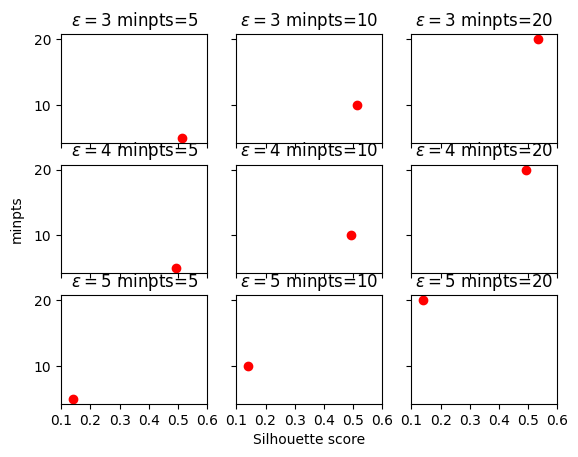

In [13]:
def dbscan_ss(df, epsilon = [3, 4, 5], minpts = [5, 10, 20]):
    hyper_params = list(itertools.product(epsilon, minpts))
    subplot_square_len = int(np.ceil(np.sqrt(len(hyper_params))))
    fig, ax = plt.subplots(ncols=subplot_square_len, nrows=subplot_square_len, sharex=True, sharey=True)
    ss = []
    eps = []
    mp = []
    #markers = ['o', 'x']
    #plot_markers = []

    #marker_map = {str(e): marker for e,marker in zip(epsilon, markers)}
    for hp, ax in zip(hyper_params, ax.flat):
        i_epsilon = hp[0]
        i_minpts = hp[1]
        dbscan = DBSCAN(eps=i_epsilon, min_samples=i_minpts)
        dbscan.fit(df)
        ss = silhouette_score(df, dbscan.labels_)
        #plot_markers.append(marker_map[str(i_epsilon)])
        ax.scatter(ss, i_minpts, color = 'red')
        ax.set_title(f'$\epsilon=${i_epsilon} minpts={i_minpts}')
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Silhouette score")
    plt.ylabel("minpts")

dbscan_ss(df_scaled)


In [14]:
def run_pilot_dbscan_cluster(df, epsilon, min_pts):
    dbscan = DBSCAN(eps=epsilon, min_samples=min_pts)
    dbscan.fit(df)
    return(dbscan.labels_)
pilot_dbscan_classes = run_pilot_dbscan_cluster(df_scaled, epsilon=3, min_pts=20)
print(set(pilot_dbscan_classes))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


## Pilot OPTICS

In [15]:
def optics_ss(df, min_samples = [3, 5, 7, 10, 20, 50]):
    results = {'m': [], 'ss': []}
    for m in min_samples:
        optics = OPTICS(min_samples=m)
        optics.fit(df)
        ss = silhouette_score(df, optics.labels_)
        print(ss)
        results['m'].append(m)
        results['ss'].append(ss)
    return(results)
res_pilot_optics = optics_ss(df_scaled)

-0.6464934769124937
-0.621813624090342
0.07259766176157438
0.5038696434207874
0.521377191915671
0.4841621065116784


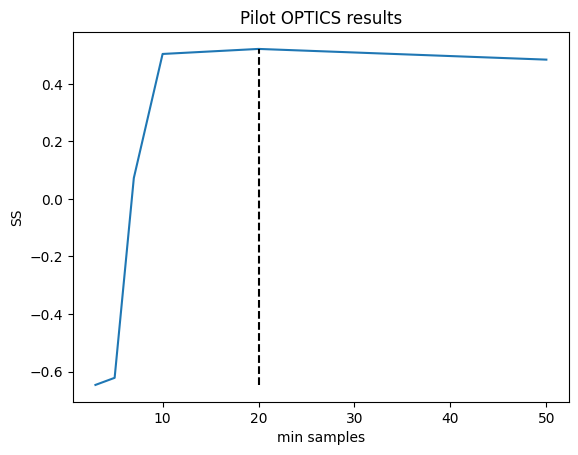

In [16]:
def plot_optics_res(res):
    min_ss = min(res['ss'])
    max_ss = max(res['ss'])
    idx_max_ss = res['ss'].index(max_ss)
    best_min_samples = res['m'][idx_max_ss]
    plt.plot(res['m'], res['ss'])
    plt.vlines(best_min_samples, ymin = min_ss, ymax = max_ss, linestyles= 'dashed', colors= 'black')
    plt.xlabel('min samples')
    plt.ylabel('SS')
    plt.title('Pilot OPTICS results')
    return(best_min_samples)
pilot_optics_min_samples = plot_optics_res(res_pilot_optics)

In [17]:
def run_pilot_optics_cluster(df, min_samples):
    optics = OPTICS(min_samples=min_samples)
    optics.fit(df)
    return(optics.labels_)
pilot_optics_classes = run_pilot_optics_cluster(df_scaled, pilot_optics_min_samples)
print(set(pilot_optics_classes))

{0, 1, 2, 3, 4, 5, 6, 7, 8}


## Pilot rand index comparisons

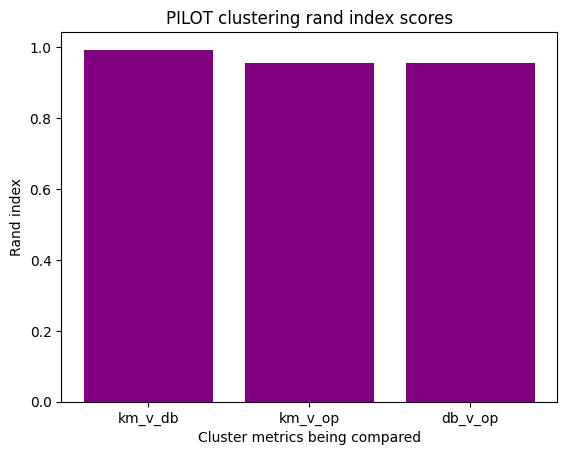

In [18]:
def plot_pilot_rand_scores():
    cluster_results = {'kmeans': pilot_kmeans_classes, 'dbscan': pilot_dbscan_classes, 'optics': pilot_optics_classes}
    k_v_d = rand_score(cluster_results['kmeans'], cluster_results['dbscan'])
    k_v_o = rand_score(cluster_results['kmeans'], cluster_results['optics'])
    d_v_o = rand_score(cluster_results['dbscan'], cluster_results['optics'])
    labels = ['km_v_db', 'km_v_op', 'db_v_op']
    plt.bar(x=labels, height=[k_v_d, k_v_o, d_v_o], label = labels, color = ['purple', 'purple', 'purple'])
    plt.xlabel("Cluster metrics being compared")
    plt.ylabel("Rand index")
    plt.title("PILOT clustering rand index scores")


plot_pilot_rand_scores()


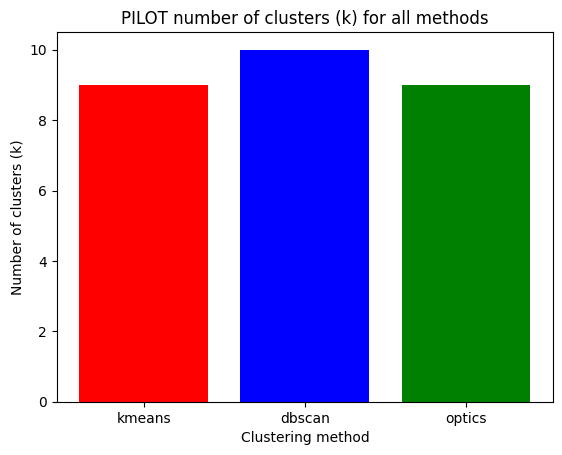

In [19]:
def plot_pilot_cluster_numbers_by_method():
    cluster_results = {'kmeans': pilot_kmeans_classes, 'dbscan': pilot_dbscan_classes, 'optics': pilot_optics_classes}
    k_kmeans = len(set(cluster_results['kmeans']))
    k_dbscan = len(set(cluster_results['dbscan'])) - 1
    k_optics = len(set(cluster_results['optics']))
    labels = ['kmeans', 'dbscan', 'optics']
    plt.bar(x = labels, height= [k_kmeans, k_dbscan, k_optics], label = labels, color = ['red', 'blue', 'green'])
    plt.xlabel("Clustering method")
    plt.ylabel("Number of clusters (k)")
    plt.title("PILOT number of clusters (k) for all methods")

plot_pilot_cluster_numbers_by_method()


## Q2

- Use rand index to compare labels and ground truth
- Use LDA as a supervised classification method, making use of ground truth

In [20]:
df_test = pd.read_excel("./Test_GeneExpressionData.xlsx")
df_test["Coded cell type"]

0      9
1      8
2     10
3      1
4      1
      ..
95    10
96     5
97     6
98     2
99     1
Name: Coded cell type, Length: 100, dtype: int64

In [21]:
# scale test data (not the ground truth col)
df_test_X = df_test.copy().drop(columns=["Coded cell type"])
scaler_test = StandardScaler()
scaler_test.fit(df_test_X)
df_scaled_test = df_test.copy()
df_scaled_test.iloc[:, 0:100] = scaler_test.transform(df_test_X)
df_scaled_test_X = df_scaled_test.copy().drop(columns=["Coded cell type"])
df_scaled_test

,Expression - gene 000,Expression - gene 001,Expression - gene 002,Expression - gene 003,Expression - gene 004,Expression - gene 005,Expression - gene 006,Expression - gene 007,Expression - gene 008,Expression - gene 009,...,Expression - gene 091,Expression - gene 092,Expression - gene 093,Expression - gene 094,Expression - gene 095,Expression - gene 096,Expression - gene 097,Expression - gene 098,Expression - gene 099,Coded cell type
0,0.576474,-0.046709,-1.431780,0.812936,0.812936,-1.247196,1.620047,-1.328680,1.598928,-0.662017,...,0.312100,-0.886910,0.336760,-0.987109,-0.521694,-0.521694,1.140443,-0.763066,0.851594,9
1,-0.694343,0.473991,1.206428,-0.852122,-0.852122,1.248843,-1.332160,1.151981,-0.627216,0.889610,...,-0.384160,-0.390866,0.540604,-0.316578,-0.195622,-0.195622,0.212612,0.372434,-0.223388,8
2,-1.121339,0.862606,1.283640,-1.047887,-1.047887,1.187681,-1.108111,1.204512,0.204128,1.060460,...,-0.509613,0.207483,0.733840,0.478792,-0.093164,-0.093164,-1.631647,0.692928,-0.939225,10
3,1.645442,-1.748691,-1.229732,1.439391,1.439391,-1.290989,1.000507,-1.230958,-1.546088,-1.519826,...,0.618481,-0.156706,-0.025186,-0.199564,-0.305502,-0.305502,0.023865,-0.519466,0.467271,1
4,1.542575,-1.463493,-1.272966,1.348099,1.348099,-1.282616,1.039354,-1.243644,-1.256100,-1.430188,...,0.115370,0.390491,-0.587413,0.318805,0.276816,0.276816,0.031445,-0.225005,0.112579,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.268986,1.003947,1.475329,-1.219905,-1.219905,1.441157,-1.385614,1.438440,0.225119,1.259372,...,-0.507645,0.204270,0.289780,0.364747,0.093638,0.093638,-0.855024,0.580912,-0.675893,10
96,-0.345284,0.171827,0.600137,-0.493191,-0.493191,0.618663,-0.631956,0.595628,-0.407995,0.431964,...,-1.629370,1.266371,-1.630436,1.062781,1.638541,1.638541,1.129232,1.425477,-1.004751,5
97,0.017474,0.016372,-0.415842,0.272049,0.272049,-0.442409,0.532131,-0.394764,0.781999,-0.196737,...,-0.678932,0.666955,-0.362870,0.765796,0.564210,0.564210,-0.721537,0.456071,-0.660655,6
98,1.659778,-1.417661,-1.853133,1.895494,1.895494,-1.863774,1.980203,-1.969616,-0.346938,-1.778385,...,-0.091339,-0.638608,1.497784,-0.335654,-0.797636,-0.797636,-1.129439,0.132234,-0.272219,2


### K-means

In [22]:
np.array(df_scaled_test["Coded cell type"])

array([ 9,  8, 10,  1,  1,  7,  2,  3,  7,  4,  2,  6,  8,  7,  3,  5,  2,
        3,  6,  2,  3,  5,  7,  6,  5,  7,  7,  6,  1,  5,  7,  4,  1,  6,
        6,  2, 10,  9,  8,  4,  9,  5,  1,  4,  1,  1,  1,  6,  6,  1,  2,
        5,  2,  6,  1,  3,  1,  4, 10,  4,  7,  6,  6,  7, 10,  7, 10,  3,
        7,  4,  3,  6, 10,  6,  4,  8,  5,  8,  4,  4,  2,  2,  7,  2,  2,
        3,  6,  7,  6,  5,  1,  1,  3,  4,  7, 10,  5,  6,  2,  1])

In [23]:
def test_kmeans(df):
    kmeans = KMeans(n_clusters=9, init='k-means++')
    kmeans.fit(df)
    return(kmeans.labels_)
res_test_kmeans = test_kmeans(df_scaled_test_X)
res_test_kmeans_v_gt = rand_score(np.array(df_scaled_test["Coded cell type"]), res_test_kmeans)
res_test_kmeans_v_gt

/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.9929292929292929

In [24]:
def test_dbscan(df):
    dbscan = DBSCAN(eps=3, min_samples=20)
    dbscan.fit(df)
    return(dbscan.labels_)
res_test_dbscan = test_dbscan(df_scaled_test_X)
res_test_dbscan_v_gt = rand_score(np.array(df_scaled_test["Coded cell type"]), res_test_dbscan)
res_test_dbscan_v_gt

0.10686868686868686

In [25]:
def test_optics(df):
    optics = OPTICS(min_samples=20)
    optics.fit(df)
    return(optics.labels_)
res_test_optics = test_optics(df_scaled_test_X)
res_test_optics_v_gt = rand_score(np.array(df_scaled_test["Coded cell type"]), res_test_optics)
res_test_optics_v_gt

0.4856565656565657

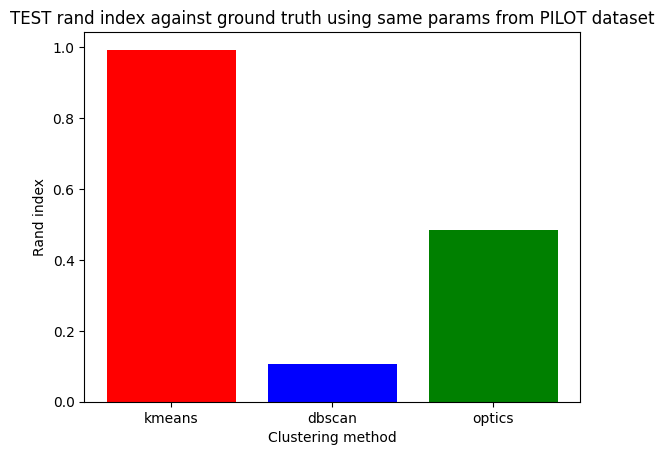

In [26]:
def plot_perf_against_gt(kmeans, dbscan, optics):
    labels = ['kmeans', 'dbscan', 'optics']
    plt.bar(x = labels, height= [kmeans, dbscan, optics], label = labels, color = ['red', 'blue', 'green'])
    plt.xlabel("Clustering method")
    plt.ylabel("Rand index")
    plt.title("TEST rand index against ground truth using same params from PILOT dataset")
plot_perf_against_gt(res_test_kmeans_v_gt, res_test_dbscan_v_gt, res_test_optics_v_gt)

In [27]:
def test_lda(X, y):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    res = lda.predict(X)
    return(res)
res_test_lda = test_lda(df_scaled_test_X, df_scaled_test["Coded cell type"])
res_test_lda_v_gt = rand_score(np.array(df_scaled_test["Coded cell type"]), res_test_lda)
res_test_lda_v_gt


1.0

0.9929292929292929
0.10686868686868686
0.4856565656565657


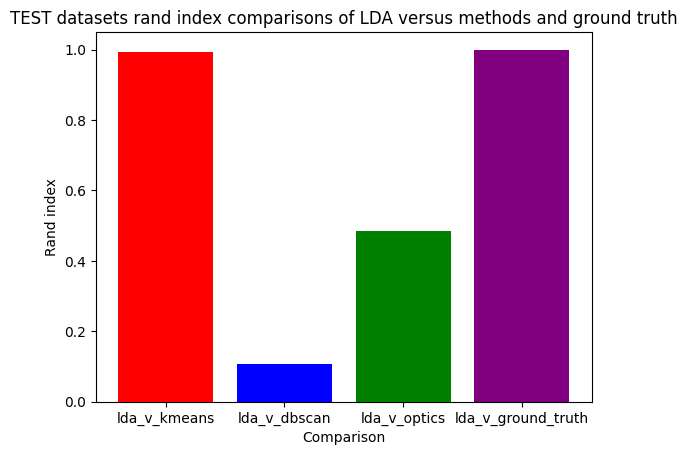

In [28]:
def plot_lda_perf_against_all(res_kmeans, res_dbscan, res_optics, res_lda, gt):
    lda_v_kmeans = rand_score(res_lda, res_kmeans)
    print(lda_v_kmeans)
    lda_v_dbscan = rand_score(res_lda, res_dbscan)
    print(lda_v_dbscan)
    lda_v_optics = rand_score(res_lda, res_optics)
    print(lda_v_optics)
    lda_v_gt = rand_score(gt, res_lda)
    labels = ['lda_v_kmeans', 'lda_v_dbscan', 'lda_v_optics', "lda_v_ground_truth"]
    plt.bar(x = labels, height= [lda_v_kmeans, lda_v_dbscan, lda_v_optics, lda_v_gt], label = labels, color = ['red', 'blue', 'green', 'purple'])
    plt.xlabel("Comparison")
    plt.ylabel("Rand index")
    plt.title("TEST datasets rand index comparisons of LDA versus methods and ground truth")
plot_lda_perf_against_all(res_test_kmeans, res_test_dbscan, res_test_optics, res_test_lda, df_scaled_test["Coded cell type"])

array([ 9,  8, 10,  1,  1,  7,  2,  3,  7,  4,  2,  6,  8,  7,  3,  5,  2,
        3,  6,  2,  3,  5,  7,  6,  5,  7,  7,  6,  1,  5,  7,  4,  1,  6,
        6,  2, 10,  9,  8,  4,  9,  5,  1,  4,  1,  1,  1,  6,  6,  1,  2,
        5,  2,  6,  1,  3,  1,  4, 10,  4,  7,  6,  6,  7, 10,  7, 10,  3,
        7,  4,  3,  6, 10,  6,  4,  8,  5,  8,  4,  4,  2,  2,  7,  2,  2,
        3,  6,  7,  6,  5,  1,  1,  3,  4,  7, 10,  5,  6,  2,  1])